In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import  numpy as np
import seaborn as sns

In [66]:
def plot_func(y_test, y_pred, train=None, name=None):
    # Set up a (1,4) grid of plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Code 1: Scatter plot
    axes[0].scatter(y_test, y_pred)
    axes[0].set_xlabel('True Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Scatter Plot of True vs. Predicted Values')

    # Calculate thresholds and misclassification rates
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    
    # Determine the threshold with the minimum misclassification rate
    optimal_threshold = thresholds[np.argmin(misclassification_rates)]

    # Code 2: Confusion matrix heatmap
    y_pred_class = (y_pred > optimal_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('True labels')
    axes[1].set_title(f'Confusion Matrix Heatmap - Threshold = {optimal_threshold:.2f}')


    # Code 3: ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = roc_auc_score(y_test, y_pred)
    test_line, = axes[2].plot(fpr, tpr, color='blue', label=f'AUC_test = {auc_value:.3f}')
    axes[2].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[2].set_xlabel('False Positive Rate (FPR)')
    axes[2].set_ylabel('True Positive Rate (TPR)')
    axes[2].set_title('ROC Curve')

    # If train data provided, plot its ROC curve too
    if train is not None:
        fpr, tpr, thresholds = roc_curve(train[0], train[1])
        auc_value = roc_auc_score(train[0], train[1])
        train_line, = axes[2].plot(fpr, tpr, linestyle='--', color='blue', label=f'AUC_train = {auc_value:.3f}')

    # Legend adjustments for ROC Curve
    if train is not None:
        axes[2].legend(handles=[test_line, train_line], loc='best')
    else:
        axes[2].legend(loc='best')

    # Code 4: Misclassification Rate as function of Threshold
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    axes[3].plot(thresholds, misclassification_rates, label='Misclassification Rate')
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Misclassification Rate')
    axes[3].set_title('Misclassification Rate vs. Threshold')
    axes[3].legend(loc='best')

    fig.suptitle(name, fontsize=15)

    # Display the concatenated plots
    plt.tight_layout()
    plt.show()

    print(f'optimal_threshold :{optimal_threshold}')

def misclassification_rate(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp + fn) / (tp + tn + fp + fn)

In [4]:
df_transaction = pd.read_csv('transactions_dataset.csv', sep=';')

In [5]:
df_transaction

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051
...,...,...,...,...,...,...,...,...
63319310,2019-06-10,2020-06-12,1596284,245272,-2056.91300,5,by phone,7682
63319311,2018-12-14,2020-07-15,908253,880496,27.62760,1001,by phone,9375
63319312,2019-07-26,2020-10-29,1168247,2063314,-204.60984,101,by phone,3014
63319313,2018-05-23,2020-11-27,2319965,1287654,70.49730,17,by phone,1015


In [6]:
df_transaction.date_order = pd.to_datetime(df_transaction.date_order)
df_transaction.date_invoice = pd.to_datetime(df_transaction.date_invoice)

In [7]:
df_transaction.date_order.min()

Timestamp('2017-09-22 00:00:00')

In [8]:
df_transaction.date_order.max()

Timestamp('2019-09-22 00:00:00')

In [9]:
df_transaction['df_delta_time'] = (df_transaction.date_invoice - df_transaction.date_order).dt.days

In [10]:
df_transaction_agg = (df_transaction.assign(month = df_transaction.date_order.dt.month,
                       year = df_transaction.date_order.dt.year,
                       day = df_transaction.date_order.dt.day)
               .groupby(by=['year','month','day','client_id'])
               .agg({'sales_net': ['count', 'mean', 'sum'],
#                     'date_order': lambda x : x
                     })
)

In [11]:
df_transaction_agg

sales_net                         
                             count        mean          sum
year month day client_id                                   
2017 9     22  403403            3  221.747600   665.242800
               585799            4  163.654200   654.616800
               591886            2    0.000000     0.000000
               688261            7  349.081183  2443.568280
               791423            3  110.344800   331.034400
...                            ...         ...          ...
2019 9     22  2039787           1  151.982160   151.982160
               2058530           3  467.707190  1403.121571
               2076261           1  166.037000   166.037000
               2153179           6  236.545800  1419.274800
               2265063          16  141.587559  2265.400947

[7955289 rows x 3 columns]

In [12]:
df_transaction_agg['date'] = pd.to_datetime(
    df_transaction_agg.index.get_level_values(0).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(1).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(2).astype(str)
)


In [13]:
df_transaction_agg = df_transaction_agg.droplevel([0,1,2])

In [14]:
df_transaction_agg.index.value_counts()

client_id
1162413    576
705312     568
1444500    560
1890528    558
1061219    553
          ... 
2222254      1
2213723      1
2135388      1
2042147      1
1630903      1
Name: count, Length: 170589, dtype: int64

array([[<AxesSubplot:title={'center':'client_id'}>]], dtype=object)

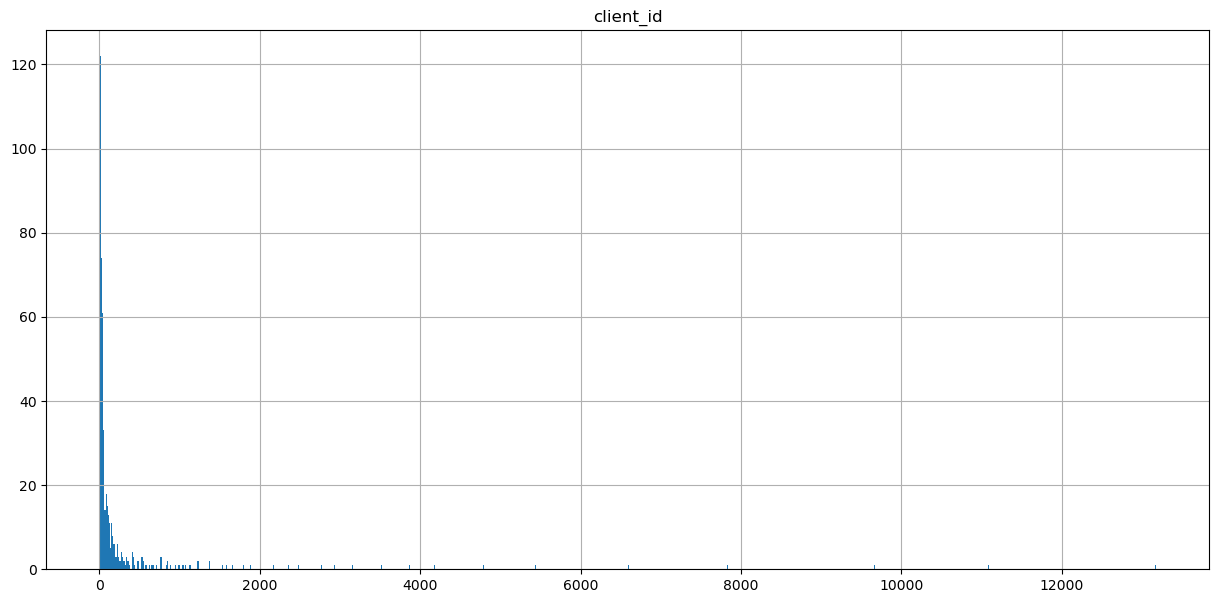

In [15]:
pd.DataFrame(df_transaction_agg.index.value_counts()[:-10000]).assign( client_id = lambda x : x.index ).groupby(by='count').count().hist(bins=1000, figsize=(15,7))

In [16]:
df_transaction_agg.index.value_counts()[df_transaction_agg.index.value_counts().gt(1)].sum()

7934208

In [17]:
df_transaction_agg.index.value_counts()[~df_transaction_agg.index.value_counts().gt(1)].sum()

21081

In [18]:
df_date = pd.DataFrame(df_transaction_agg['date']).groupby(by='client_id').date.apply(list)
df_date_expanded = pd.DataFrame(df_date.values.tolist(), index=df_date.index)

In [19]:
(df_date_expanded[0] - df_date_expanded[1]).dt.days

client_id
6          -33.0
7         -161.0
14          -1.0
18          -1.0
25           NaN
           ...  
2274456     -1.0
2274479   -485.0
2274504   -425.0
2274508      NaN
2274517    -30.0
Length: 170589, dtype: float64

In [20]:
df_delta = df_date_expanded.copy()
for i in range(575):
    df_delta[i] = -(df_delta[i] - df_delta[i+1]).dt.days

In [21]:
df_delta.drop(columns=[575], inplace=True)

In [22]:
df_delta.to_numpy().flatten()

array([ 33., 121.,  41., ...,  nan,  nan,  nan])

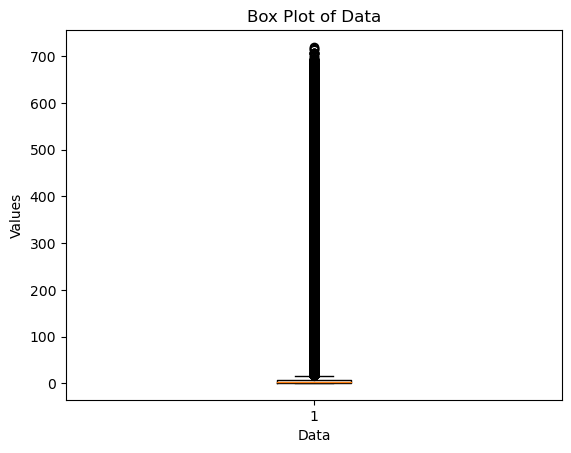

In [25]:
import matplotlib.pyplot as plt

# Assuming df_delta is your DataFrame
data = df_delta.to_numpy().flatten()
data_without_nan = data[~np.isnan(data)]

plt.boxplot(data_without_nan)
plt.title('Box Plot of Data')
plt.xlabel('Data')
plt.ylabel('Values')
plt.show()


<AxesSubplot:>

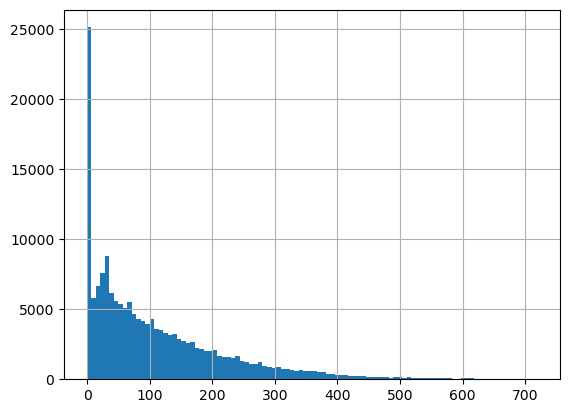

In [26]:
df_delta.fillna(-1).max(axis=1).hist(bins=100)

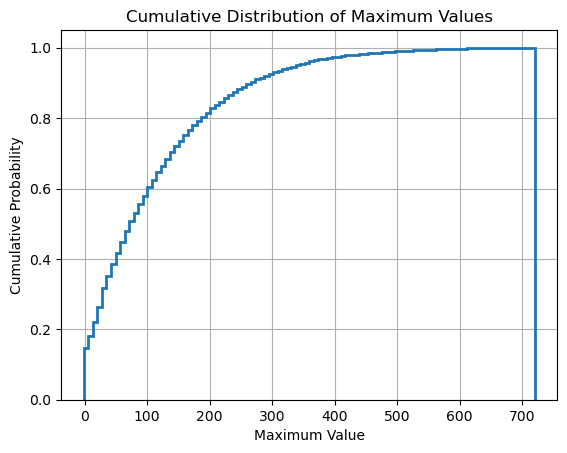

In [27]:
import matplotlib.pyplot as plt

# Assuming df_delta is your DataFrame
df_delta.fillna(-1).max(axis=1).hist(bins=100, cumulative=True, density=True, histtype='step', linewidth=2)
plt.title('Cumulative Distribution of Maximum Values')
plt.xlabel('Maximum Value')
plt.ylabel('Cumulative Probability')
plt.show()


In [28]:
import matplotlib.pyplot as plt

# Assuming df_delta is your DataFrame
df_delta.fillna(-1).to_numpy().flatten().hist(bins=100, cumulative=True, density=True, histtype='step', linewidth=2)
plt.title('Cumulative Distribution of Maximum Values')
plt.xlabel('Maximum Value')
plt.ylabel('Cumulative Probability')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'hist'

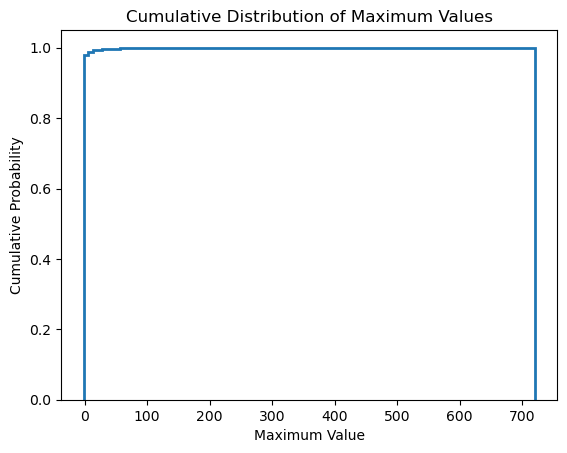

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_delta is your DataFrame
data = df_delta.fillna(-1).to_numpy().flatten()

plt.hist(data, bins=100, cumulative=True, density=True, histtype='step', linewidth=2)
plt.title('Cumulative Distribution of Maximum Values')
plt.xlabel('Maximum Value')
plt.ylabel('Cumulative Probability')
plt.show()


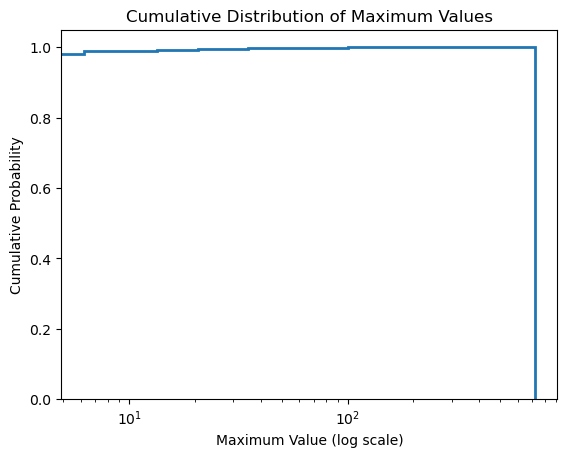

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_delta is your DataFrame
data = df_delta.fillna(-1).to_numpy().flatten()

plt.hist(data, bins=100, cumulative=True, density=True, histtype='step', linewidth=2)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Cumulative Distribution of Maximum Values')
plt.xlabel('Maximum Value (log scale)')
plt.ylabel('Cumulative Probability')
plt.show()


# Churn curve plot

In [3]:
df_transaction = pd.read_csv('transactions_dataset.csv', sep=';')

df_transaction.date_order = pd.to_datetime(df_transaction.date_order)
df_transaction.date_invoice = pd.to_datetime(df_transaction.date_invoice)

df_transaction['df_delta_time'] = (df_transaction.date_invoice - df_transaction.date_order).dt.days

In [32]:
df_transaction_agg = (df_transaction.assign(month = df_transaction.date_order.dt.month,
                       year = df_transaction.date_order.dt.year,
                       day = df_transaction.date_order.dt.day)
               .groupby(by=['year','month','day','client_id'])
               .agg({'sales_net': ['count', 'mean', 'sum'],
                     })
)

df_transaction_agg['date'] = pd.to_datetime(
    df_transaction_agg.index.get_level_values(0).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(1).astype(str) 
    + '-'
    + df_transaction_agg.index.get_level_values(2).astype(str)
)

df_transaction_agg = df_transaction_agg.droplevel([0,1,2])

df_date = pd.DataFrame(df_transaction_agg['date']).groupby(by='client_id').date.apply(list)
df_date_expanded = pd.DataFrame(df_date.values.tolist(), index=df_date.index)

df_delta = df_date_expanded.copy()
for i in range(575):
    df_delta[i] = -(df_delta[i] - df_delta[i+1]).dt.days

df_delta.drop(columns=[575], inplace=True)

#df_delta.to_numpy().flatten()

In [35]:
flat = df_delta.fillna(-1).to_numpy().flatten()

array([ 33., 121.,  41., ...,  -1.,  -1.,  -1.])

In [36]:
def get_frequence(days_array, J=30):
    freq_list = []
    pop_list = []
    for i in range(int(max(days_array))):
        freq_list.append(np.mean((days_array[days_array > i] - i) < J))
        pop_list.append(days_array[days_array > i])
    return (np.array(freq_list), np.array(pop_list))

In [38]:
import numpy as np

def value_counts_np(array):
    unique_values, counts = np.unique(array, return_counts=True)
    result = dict(zip(unique_values, counts))
    return result

# Example usage:
data = df_delta.fillna(-1).to_numpy()[:,-1]
counts = value_counts_np(data)
print(counts)


{-1.0: 170588, 1.0: 1}


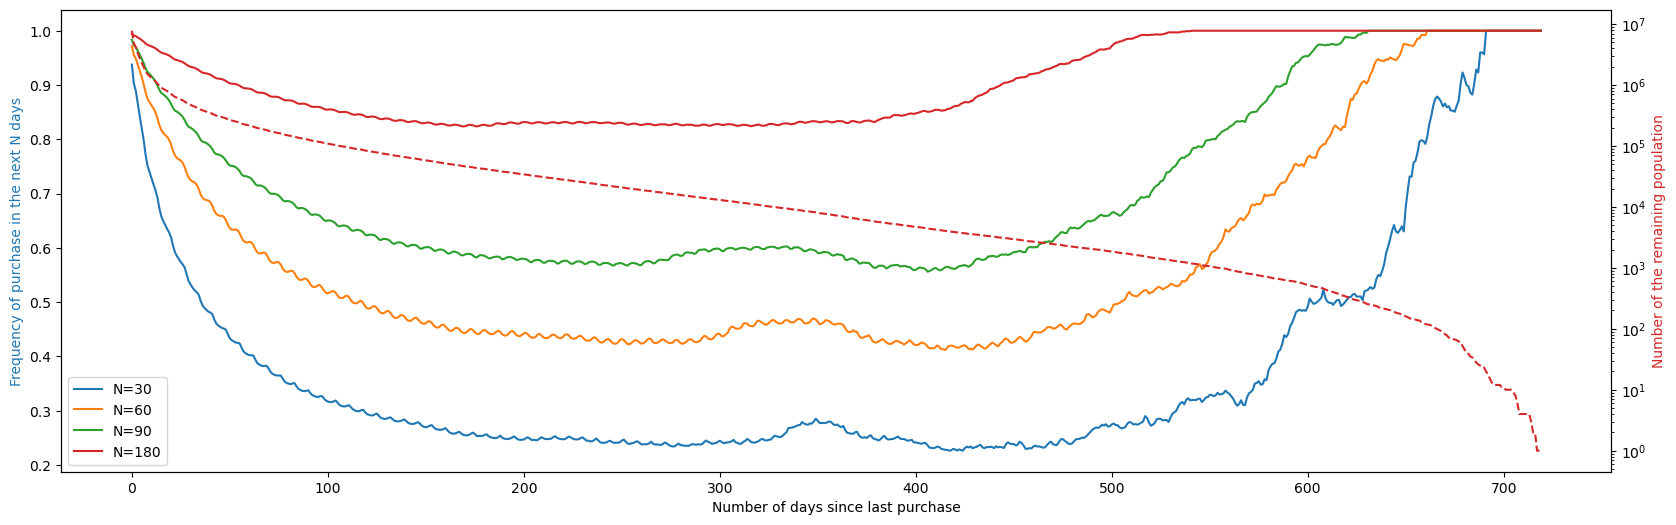

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_frequence(days_array, J=30):
    freq_list = []
    pop_list = []
    for i in range(int(max(days_array))):
        freq_list.append(np.mean((days_array[days_array > i] - i) < J))
        pop_list.append(np.sum((days_array > i)))
    return np.array(freq_list), np.array(pop_list)

fig, ax1 = plt.subplots(figsize=(20, 6))

N_list = [30, 60, 90, 180]
for N in N_list:
    freq_list, pop_list = get_frequence(flat, J=N)
    ax1.plot(freq_list, label=f'N={N}')

ax1.set_xlabel('Number of days since last purchase')
ax1.set_ylabel('Frequency of purchase in the next N days', color='tab:blue')
ax1.legend(loc='lower left')

ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis
ax2.plot(pop_list, color='tab:red', linestyle='dashed')
ax2.set_ylabel('Number of the remaining population', color='tab:red')
ax2.set_yscale('log')  # Set y-axis to logarithmic scale

plt.show()


# Test feature function

In [92]:
from preprocessing import create_features

In [93]:
def def_temp_window(df, n_days=120):
    end_date = df.date_order.max()  - pd.Timedelta(days=120)
    df_features = create_features(df, end_date)
    client_id_no_churn = df[df.date_order > end_date].client_id.to_numpy()
    df_features['is_churn'] = df_features.client_id.isin(client_id_no_churn)
    return(df_features)

In [94]:
df = def_temp_window(df_transaction, n_days=120)

In [95]:
df

,client_id,avg_nb_distinct_prod_per_order,nb_orders,time_delta,avg_freq_orders,total_sales_net,avg_basket,pct_at_the_store,pct_by_phone,pct_during_the_visit_of_a_sales_rep,pct_online,pct_other,time_since_last_order,std_order_freq,is_churn
0,6,2.700000,10,474,0.021097,3.492387e+03,349.238713,0.500000,0.500000,0.0,0.00000,0.0,101,181.0,True
1,7,7.500000,2,161,0.012422,1.190777e+03,595.388542,1.000000,0.000000,0.0,0.00000,0.0,152,113.0,False
2,14,22.407583,422,606,0.696370,2.603858e+06,6170.279778,0.085308,0.701422,0.0,0.21327,0.0,1,176.0,True
3,18,6.525210,238,605,0.393388,1.880877e+05,790.284559,0.659664,0.340336,0.0,0.00000,0.0,1,172.0,True
4,25,4.000000,1,0,0.000000,3.745861e+02,374.586096,1.000000,0.000000,0.0,0.00000,0.0,227,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161875,2274440,4.600000,20,599,0.033389,1.909148e+04,954.574212,0.700000,0.300000,0.0,0.00000,0.0,5,212.0,True
161876,2274479,2.500000,2,485,0.004124,4.959214e+02,247.960700,1.000000,0.000000,0.0,0.00000,0.0,87,342.0,False
161877,2274504,2.000000,2,425,0.004706,1.132566e+02,56.628300,0.500000,0.500000,0.0,0.00000,0.0,144,300.0,False
161878,2274508,4.000000,1,0,0.000000,7.270190e+01,72.701896,1.000000,0.000000,0.0,0.00000,0.0,584,NaN,False


In [96]:
df.is_churn.value_counts(normalize=True)

is_churn
True     0.629893
False    0.370107
Name: proportion, dtype: float64

## Test logistic regression

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame with features and 'is_churn' as the target variable
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Standardize the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0), target, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

y_train_estim = model.predict(X_train)

# Evaluate the model on the train
accuracy_train = accuracy_score(y_train, y_train_estim)
conf_matrix_train = confusion_matrix(y_train, y_train_estim)
classification_rep_train = classification_report(y_train, y_train_estim)

print(f"Accuracy (train): {accuracy_train}")
print(f"Confusion Matrix (train):\n{conf_matrix_train}")
print(f"Classification Report (train):\n{classification_rep_train}")

# Evaluate the model on the test
accuracy_test = accuracy_score(y_test, y_pred)
conf_matrix_test = confusion_matrix(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

print(f"Accuracy (test): {accuracy_test}")
print(f"Confusion Matrix (test):\n{conf_matrix_test}")
print(f"Classification Report (test):\n{classification_rep_test}")

Accuracy (train): 0.8016509142574747
Confusion Matrix (train):
[[31715 16231]
 [ 9456 72102]]
Classification Report (train):
              precision    recall  f1-score   support

       False       0.77      0.66      0.71     47946
        True       0.82      0.88      0.85     81558

    accuracy                           0.80    129504
   macro avg       0.79      0.77      0.78    129504
weighted avg       0.80      0.80      0.80    129504

Accuracy (test): 0.8039597232517914
Confusion Matrix (test):
[[ 7968  3999]
 [ 2348 18061]]
Classification Report (test):
              precision    recall  f1-score   support

       False       0.77      0.67      0.72     11967
        True       0.82      0.88      0.85     20409

    accuracy                           0.80     32376
   macro avg       0.80      0.78      0.78     32376
weighted avg       0.80      0.80      0.80     32376



<AxesSubplot:>

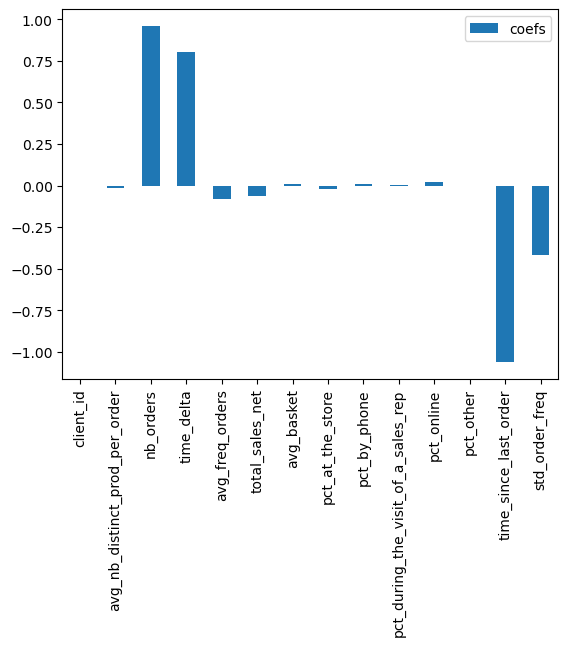

In [98]:
pd.DataFrame({'coefs' :model.coef_[0]}, features).plot.bar()

## Test XGB Classifier

In [39]:
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [57]:
# Split the dataset
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0)
                                                    , target
                                                    , test_size=0.2
                                                    , random_state=42)



# Objective function for hyperopt
def objective(params):
    model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        eval_metric='auc'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

# Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 8, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'random_state':42
}

# Run the optimizer
trials = Trials()
best_xgb = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

#print(f"Best hyperparameters:\n{best}")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  1%|          | 1/100 [00:00<01:24,  1.18trial/s, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  2%|▏         | 2/100 [00:01<01:35,  1.03trial/s, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  3%|▎         | 3/100 [00:03<01:58,  1.22s/trial, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  4%|▍         | 4/100 [00:04<01:49,  1.14s/trial, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  5%|▌         | 5/100 [00:04<01:24,  1.12trial/s, best loss: 0.1952019101084993]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  6%|▌         | 6/100 [00:05<01:30,  1.04trial/s, best loss: 0.1903620963824263]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  7%|▋         | 7/100 [00:07<01:38,  1.06s/trial, best loss: 0.1903620963824263]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  8%|▊         | 8/100 [00:07<01:20,  1.14trial/s, best loss: 0.1903620963824263]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  9%|▉         | 9/100 [00:08<01:19,  1.14trial/s, best loss: 0.1903620963824263]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 10%|█         | 10/100 [00:09<01:22,  1.09trial/s, best loss: 0.19013723871765986]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 11%|█         | 11/100 [00:10<01:30,  1.01s/trial, best loss: 0.1888395289505841] 

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 12%|█▏        | 12/100 [00:11<01:27,  1.00trial/s, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 13%|█▎        | 13/100 [00:13<01:34,  1.09s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 14%|█▍        | 14/100 [00:14<01:40,  1.17s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 15%|█▌        | 15/100 [00:14<01:22,  1.03trial/s, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 16%|█▌        | 16/100 [00:16<01:30,  1.08s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 17%|█▋        | 17/100 [00:16<01:13,  1.12trial/s, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 18%|█▊        | 18/100 [00:17<01:13,  1.12trial/s, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 19%|█▉        | 19/100 [00:19<01:24,  1.04s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 20%|██        | 20/100 [00:20<01:33,  1.17s/trial, best loss: 0.1888395289505841]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 21%|██        | 21/100 [00:21<01:29,  1.14s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 22%|██▏       | 22/100 [00:22<01:20,  1.04s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 23%|██▎       | 23/100 [00:23<01:17,  1.00s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 24%|██▍       | 24/100 [00:24<01:31,  1.20s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 25%|██▌       | 25/100 [00:26<01:32,  1.23s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 26%|██▌       | 26/100 [00:26<01:16,  1.04s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 27%|██▋       | 27/100 [00:27<01:08,  1.07trial/s, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 28%|██▊       | 28/100 [00:29<01:19,  1.10s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 29%|██▉       | 29/100 [00:30<01:25,  1.20s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 30%|███       | 30/100 [00:30<01:09,  1.01trial/s, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 31%|███       | 31/100 [00:32<01:18,  1.14s/trial, best loss: 0.1886044208913431]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 32%|███▏      | 32/100 [00:33<01:15,  1.10s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 33%|███▎      | 33/100 [00:34<01:19,  1.19s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 34%|███▍      | 34/100 [00:35<01:17,  1.18s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 35%|███▌      | 35/100 [00:37<01:22,  1.27s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 36%|███▌      | 36/100 [00:39<01:41,  1.59s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 37%|███▋      | 37/100 [00:40<01:19,  1.25s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 38%|███▊      | 38/100 [00:41<01:11,  1.16s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 39%|███▉      | 39/100 [00:41<01:03,  1.04s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 40%|████      | 40/100 [00:44<01:29,  1.49s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 41%|████      | 41/100 [00:45<01:13,  1.25s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 42%|████▏     | 42/100 [00:45<00:59,  1.02s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 43%|████▎     | 43/100 [00:47<01:04,  1.13s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 44%|████▍     | 44/100 [00:47<00:59,  1.06s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 45%|████▌     | 45/100 [00:48<00:53,  1.04trial/s, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 46%|████▌     | 46/100 [00:49<00:54,  1.01s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 47%|████▋     | 47/100 [00:52<01:23,  1.58s/trial, best loss: 0.18836986557955726]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 48%|████▊     | 48/100 [00:53<01:08,  1.32s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 49%|████▉     | 49/100 [00:54<01:01,  1.20s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 50%|█████     | 50/100 [00:55<00:51,  1.03s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 51%|█████     | 51/100 [00:56<00:54,  1.12s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 52%|█████▏    | 52/100 [00:57<00:47,  1.01trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 53%|█████▎    | 53/100 [00:58<00:52,  1.12s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 54%|█████▍    | 54/100 [00:59<00:52,  1.13s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 55%|█████▌    | 55/100 [01:01<00:59,  1.32s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 56%|█████▌    | 56/100 [01:01<00:48,  1.11s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 57%|█████▋    | 57/100 [01:03<00:48,  1.13s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 58%|█████▊    | 58/100 [01:03<00:39,  1.06trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 59%|█████▉    | 59/100 [01:05<00:44,  1.09s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 60%|██████    | 60/100 [01:05<00:36,  1.10trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 61%|██████    | 61/100 [01:06<00:30,  1.29trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 62%|██████▏   | 62/100 [01:07<00:31,  1.21trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 63%|██████▎   | 63/100 [01:08<00:35,  1.05trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 64%|██████▍   | 64/100 [01:08<00:30,  1.18trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 65%|██████▌   | 65/100 [01:10<00:37,  1.08s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 66%|██████▌   | 66/100 [01:12<00:41,  1.22s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 67%|██████▋   | 67/100 [01:12<00:36,  1.12s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 68%|██████▊   | 68/100 [01:13<00:31,  1.02trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 69%|██████▉   | 69/100 [01:14<00:29,  1.07trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 70%|███████   | 70/100 [01:15<00:29,  1.03trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 71%|███████   | 71/100 [01:16<00:30,  1.06s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 72%|███████▏  | 72/100 [01:17<00:28,  1.02s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 73%|███████▎  | 73/100 [01:19<00:31,  1.15s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 74%|███████▍  | 74/100 [01:20<00:32,  1.23s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 75%|███████▌  | 75/100 [01:21<00:30,  1.22s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 76%|███████▌  | 76/100 [01:22<00:27,  1.15s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 77%|███████▋  | 77/100 [01:24<00:30,  1.34s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 78%|███████▊  | 78/100 [01:26<00:36,  1.64s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 79%|███████▉  | 79/100 [01:28<00:31,  1.51s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 80%|████████  | 80/100 [01:29<00:27,  1.38s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 81%|████████  | 81/100 [01:30<00:23,  1.26s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 82%|████████▏ | 82/100 [01:30<00:18,  1.03s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 83%|████████▎ | 83/100 [01:31<00:15,  1.12trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 84%|████████▍ | 84/100 [01:32<00:14,  1.08trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 85%|████████▌ | 85/100 [01:32<00:12,  1.23trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 86%|████████▌ | 86/100 [01:33<00:10,  1.34trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 87%|████████▋ | 87/100 [01:34<00:12,  1.08trial/s, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 88%|████████▊ | 88/100 [01:36<00:14,  1.22s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 89%|████████▉ | 89/100 [01:38<00:15,  1.45s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 90%|█████████ | 90/100 [01:39<00:11,  1.17s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 91%|█████████ | 91/100 [01:40<00:12,  1.38s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 92%|█████████▏| 92/100 [01:41<00:10,  1.26s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 93%|█████████▎| 93/100 [01:42<00:07,  1.09s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 94%|█████████▍| 94/100 [01:43<00:06,  1.05s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 95%|█████████▌| 95/100 [01:45<00:06,  1.38s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 96%|█████████▌| 96/100 [01:47<00:05,  1.38s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 97%|█████████▋| 97/100 [01:48<00:04,  1.34s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 98%|█████████▊| 98/100 [01:49<00:02,  1.29s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 99%|█████████▉| 99/100 [01:51<00:01,  1.43s/trial, best loss: 0.18760773124671903]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

100%|██████████| 100/100 [01:52<00:00,  1.12s/trial, best loss: 0.18760773124671903]


/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

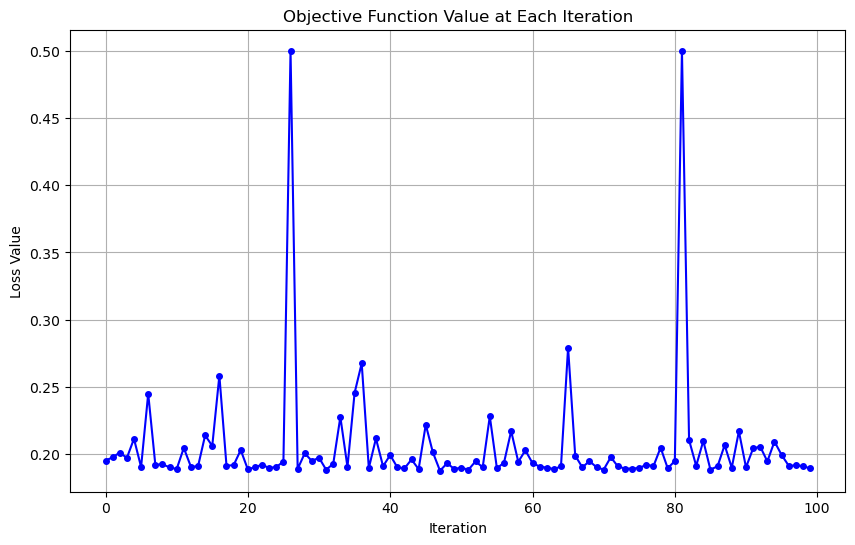

In [58]:
losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

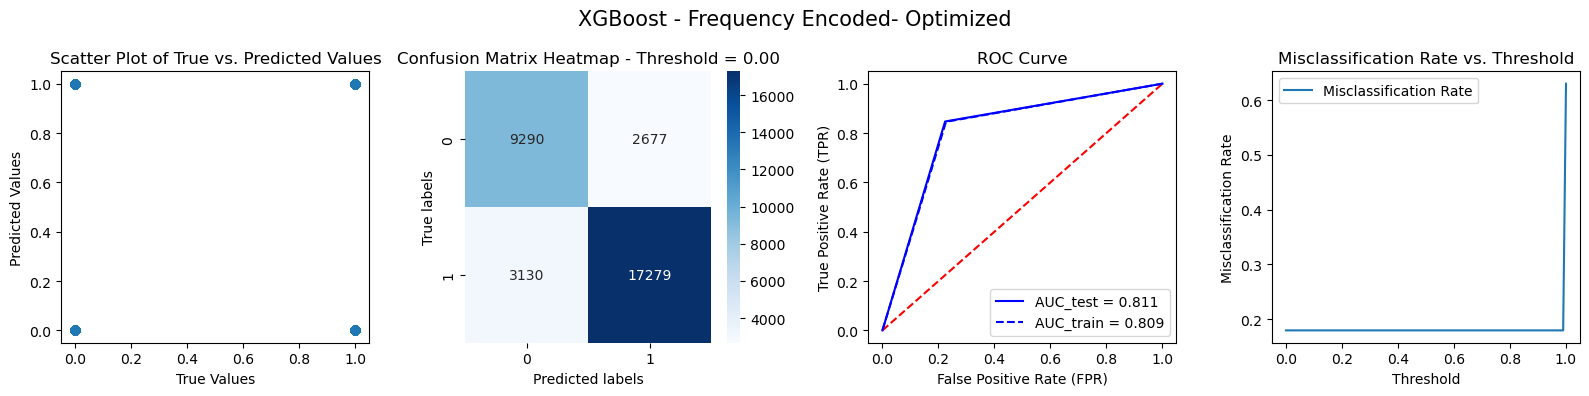

In [59]:
# Split the dataset
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0)
                                                    , target
                                                    , test_size=0.2
                                                    , random_state=42)


# 5. Perform regression using CatBoost

best_xgb['max_depth'] = int(best_xgb['max_depth'])

best_hyperparameters = best_xgb

regressor_xgb = xgb.XGBClassifier(**best_hyperparameters)
regressor_xgb.fit(X_train, y_train)

# Predict
y_pred = regressor_xgb.predict(X_test)

plot_func(y_test, y_pred, train=(y_train, regressor_xgb.predict(X_train)), name='XGBoost - Frequency Encoded- Optimized')

In [60]:
# Make predictions on the test set
y_pred = regressor_xgb.predict(X_test)

y_train_estim = regressor_xgb.predict(X_train)

# Evaluate the model on the train
accuracy_train = accuracy_score(y_train, y_train_estim)
conf_matrix_train = confusion_matrix(y_train, y_train_estim)
classification_rep_train = classification_report(y_train, y_train_estim)

print(f"Accuracy (train): {accuracy_train}")
print(f"Confusion Matrix (train):\n{conf_matrix_train}")
print(f"Classification Report (train):\n{classification_rep_train}")


# Evaluate the model on the test
accuracy_test = accuracy_score(y_test, y_pred)
conf_matrix_test = confusion_matrix(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

print(f"Accuracy (test): {accuracy_test}")
print(f"Confusion Matrix (test):\n{conf_matrix_test}")
print(f"Classification Report (test):\n{classification_rep_test}")

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

Accuracy (train): 0.8186310847541388
Confusion Matrix (train):
[[37062 10884]
 [12604 68954]]
Classification Report (train):
              precision    recall  f1-score   support

       False       0.75      0.77      0.76     47946
        True       0.86      0.85      0.85     81558

    accuracy                           0.82    129504
   macro avg       0.80      0.81      0.81    129504
weighted avg       0.82      0.82      0.82    129504

Accuracy (test): 0.820638744749197
Confusion Matrix (test):
[[ 9290  2677]
 [ 3130 17279]]
Classification Report (test):
              precision    recall  f1-score   support

       False       0.75      0.78      0.76     11967
        True       0.87      0.85      0.86     20409

    accuracy                           0.82     32376
   macro avg       0.81      0.81      0.81     32376
weighted avg       0.82      0.82      0.82     32376



## Test XGB Regressor

In [61]:
# Split the dataset
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0)
                                                    , target
                                                    , test_size=0.2
                                                    , random_state=42)



# Objective function for hyperopt
def objective(params):
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        eval_metric='auc'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

# Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 8, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'random_state':42
}

# Run the optimizer
trials = Trials()
best_xgb = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

#print(f"Best hyperparameters:\n{best}")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  1%|          | 1/100 [00:00<00:40,  2.47trial/s, best loss: 0.11811703770617543]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  2%|▏         | 2/100 [00:01<01:04,  1.53trial/s, best loss: 0.10435305694707675]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  3%|▎         | 3/100 [00:02<01:10,  1.38trial/s, best loss: 0.10435305694707675]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  4%|▍         | 4/100 [00:02<00:56,  1.69trial/s, best loss: 0.10435305694707675]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  5%|▌         | 5/100 [00:04<01:39,  1.04s/trial, best loss: 0.10417843378992209]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  6%|▌         | 6/100 [00:04<01:27,  1.07trial/s, best loss: 0.10417843378992209]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  7%|▋         | 7/100 [00:05<01:10,  1.31trial/s, best loss: 0.10417843378992209]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  8%|▊         | 8/100 [00:07<01:42,  1.12s/trial, best loss: 0.10417843378992209]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

  9%|▉         | 9/100 [00:09<02:14,  1.48s/trial, best loss: 0.10417843378992209]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 10%|█         | 10/100 [00:10<01:53,  1.26s/trial, best loss: 0.1012739670119418]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 11%|█         | 11/100 [00:11<01:40,  1.13s/trial, best loss: 0.1012739670119418]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 12%|█▏        | 12/100 [00:12<01:35,  1.08s/trial, best loss: 0.1012739670119418]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 13%|█▎        | 13/100 [00:12<01:15,  1.15trial/s, best loss: 0.1012739670119418]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 14%|█▍        | 14/100 [00:12<01:01,  1.39trial/s, best loss: 0.1012739670119418]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 15%|█▌        | 15/100 [00:13<01:01,  1.39trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 16%|█▌        | 16/100 [00:14<01:11,  1.17trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 17%|█▋        | 17/100 [00:15<01:11,  1.16trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 18%|█▊        | 18/100 [00:16<01:06,  1.23trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 19%|█▉        | 19/100 [00:16<00:55,  1.45trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 20%|██        | 20/100 [00:17<00:54,  1.48trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 21%|██        | 21/100 [00:18<00:55,  1.42trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 22%|██▏       | 22/100 [00:19<00:58,  1.33trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 23%|██▎       | 23/100 [00:20<01:05,  1.17trial/s, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 24%|██▍       | 24/100 [00:22<01:31,  1.20s/trial, best loss: 0.1004951642725106]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 25%|██▌       | 25/100 [00:23<01:27,  1.17s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 26%|██▌       | 26/100 [00:23<01:13,  1.00trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 27%|██▋       | 27/100 [00:25<01:26,  1.19s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 28%|██▊       | 28/100 [00:26<01:24,  1.18s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 29%|██▉       | 29/100 [00:27<01:07,  1.06trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 30%|███       | 30/100 [00:28<01:16,  1.09s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 31%|███       | 31/100 [00:29<01:04,  1.07trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 32%|███▏      | 32/100 [00:29<00:58,  1.16trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 33%|███▎      | 33/100 [00:31<01:16,  1.14s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 34%|███▍      | 34/100 [00:32<01:05,  1.01trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 35%|███▌      | 35/100 [00:32<00:59,  1.09trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 36%|███▌      | 36/100 [00:34<01:06,  1.05s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 37%|███▋      | 37/100 [00:35<01:15,  1.20s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 38%|███▊      | 38/100 [00:37<01:23,  1.35s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 39%|███▉      | 39/100 [00:38<01:17,  1.26s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 40%|████      | 40/100 [00:40<01:21,  1.36s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 41%|████      | 41/100 [00:41<01:14,  1.26s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 42%|████▏     | 42/100 [00:43<01:35,  1.64s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 43%|████▎     | 43/100 [00:45<01:39,  1.75s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 44%|████▍     | 44/100 [00:46<01:19,  1.42s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 45%|████▌     | 45/100 [00:47<01:08,  1.25s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 46%|████▌     | 46/100 [00:47<00:54,  1.00s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 47%|████▋     | 47/100 [00:48<00:50,  1.05trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 48%|████▊     | 48/100 [00:48<00:39,  1.32trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 49%|████▉     | 49/100 [00:49<00:35,  1.44trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 50%|█████     | 50/100 [00:49<00:29,  1.69trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 51%|█████     | 51/100 [00:50<00:28,  1.71trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 52%|█████▏    | 52/100 [00:50<00:26,  1.78trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 53%|█████▎    | 53/100 [00:52<00:46,  1.01trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 54%|█████▍    | 54/100 [00:53<00:36,  1.26trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 55%|█████▌    | 55/100 [00:53<00:36,  1.23trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 56%|█████▌    | 56/100 [00:54<00:29,  1.47trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 57%|█████▋    | 57/100 [00:55<00:39,  1.08trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 58%|█████▊    | 58/100 [00:57<00:44,  1.06s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 59%|█████▉    | 59/100 [00:59<00:58,  1.43s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 60%|██████    | 60/100 [00:59<00:44,  1.11s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 61%|██████    | 61/100 [01:00<00:43,  1.13s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 62%|██████▏   | 62/100 [01:02<00:44,  1.16s/trial, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 63%|██████▎   | 63/100 [01:02<00:36,  1.01trial/s, best loss: 0.10042509022568347]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 64%|██████▍   | 64/100 [01:04<00:42,  1.17s/trial, best loss: 0.10038236080018559]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 65%|██████▌   | 65/100 [01:06<00:45,  1.31s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 66%|██████▌   | 66/100 [01:07<00:46,  1.38s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 67%|██████▋   | 67/100 [01:09<00:48,  1.46s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 68%|██████▊   | 68/100 [01:11<00:51,  1.61s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 69%|██████▉   | 69/100 [01:13<00:53,  1.71s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 70%|███████   | 70/100 [01:14<00:50,  1.69s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 71%|███████   | 71/100 [01:16<00:49,  1.70s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 72%|███████▏  | 72/100 [01:18<00:50,  1.79s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 73%|███████▎  | 73/100 [01:20<00:46,  1.71s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 74%|███████▍  | 74/100 [01:21<00:42,  1.62s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 75%|███████▌  | 75/100 [01:23<00:45,  1.81s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 76%|███████▌  | 76/100 [01:25<00:42,  1.79s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 77%|███████▋  | 77/100 [01:26<00:39,  1.71s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 78%|███████▊  | 78/100 [01:28<00:35,  1.61s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 79%|███████▉  | 79/100 [01:29<00:33,  1.62s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 80%|████████  | 80/100 [01:31<00:34,  1.70s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 81%|████████  | 81/100 [01:34<00:35,  1.88s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 82%|████████▏ | 82/100 [01:35<00:31,  1.73s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 83%|████████▎ | 83/100 [01:37<00:32,  1.94s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 84%|████████▍ | 84/100 [01:39<00:28,  1.76s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 85%|████████▌ | 85/100 [01:40<00:25,  1.73s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 86%|████████▌ | 86/100 [01:42<00:23,  1.69s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 87%|████████▋ | 87/100 [01:44<00:24,  1.87s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 88%|████████▊ | 88/100 [01:46<00:21,  1.77s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 89%|████████▉ | 89/100 [01:48<00:20,  1.87s/trial, best loss: 0.10037717930459644]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 90%|█████████ | 90/100 [01:50<00:18,  1.82s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 91%|█████████ | 91/100 [01:51<00:16,  1.79s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 92%|█████████▏| 92/100 [01:52<00:10,  1.36s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 93%|█████████▎| 93/100 [01:54<00:11,  1.61s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 94%|█████████▍| 94/100 [01:54<00:07,  1.24s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 95%|█████████▌| 95/100 [01:55<00:05,  1.20s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 96%|█████████▌| 96/100 [01:57<00:05,  1.27s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 97%|█████████▋| 97/100 [01:59<00:04,  1.39s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 98%|█████████▊| 98/100 [01:59<00:02,  1.12s/trial, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

 99%|█████████▉| 99/100 [01:59<00:00,  1.12trial/s, best loss: 0.10036276283208023]

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

100%|██████████| 100/100 [02:01<00:00,  1.21s/trial, best loss: 0.10036276283208023]


/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remov

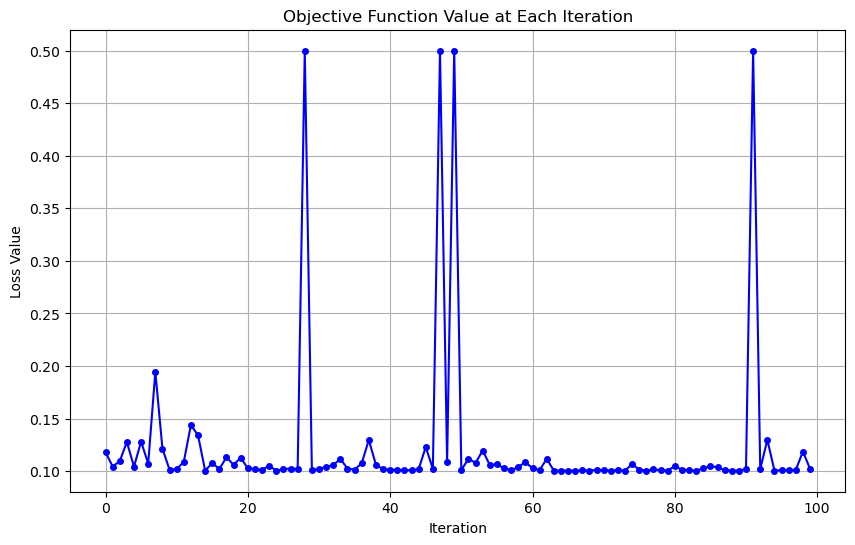

In [62]:
losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

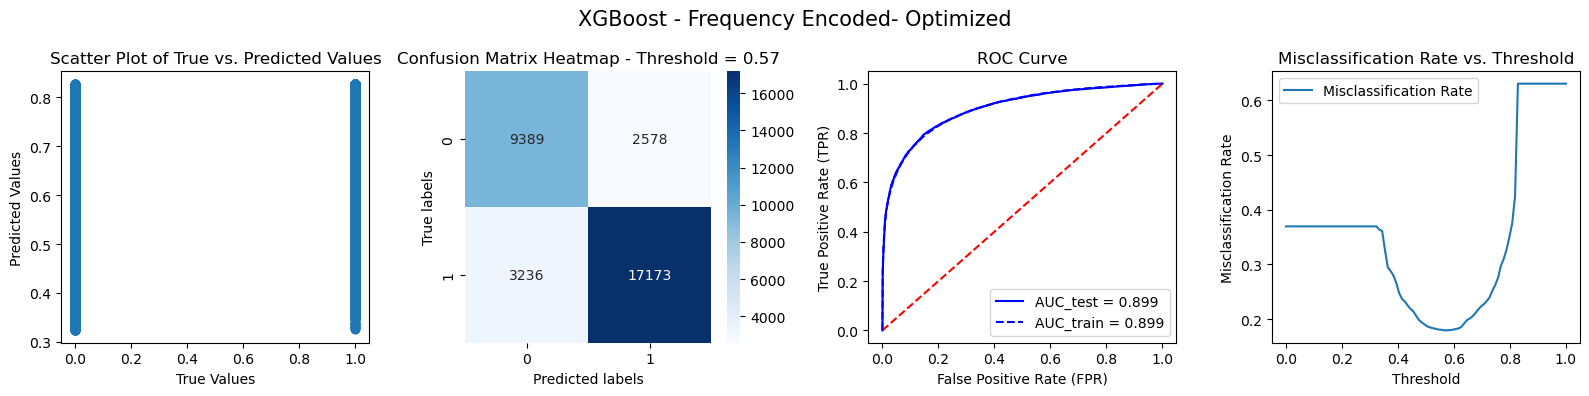

optimal_threshold :0.5656565656565657


In [67]:
# Split the dataset
# Replace 'features' with the actual features you want to use for prediction
features = list(df.columns)[:-1]

# Replace 'is_churn' with the actual target variable
target = df['is_churn']

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features].fillna(0)
                                                    , target
                                                    , test_size=0.2
                                                    , random_state=42)


# 5. Perform regression using CatBoost

best_xgb['max_depth'] = int(best_xgb['max_depth'])

best_hyperparameters = best_xgb

regressor_xgb = xgb.XGBRegressor(**best_hyperparameters)
regressor_xgb.fit(X_train, y_train)

# Predict
y_pred = regressor_xgb.predict(X_test)

plot_func(y_test, y_pred, train=(y_train, regressor_xgb.predict(X_train)), name='XGBoost - Frequency Encoded- Optimized')

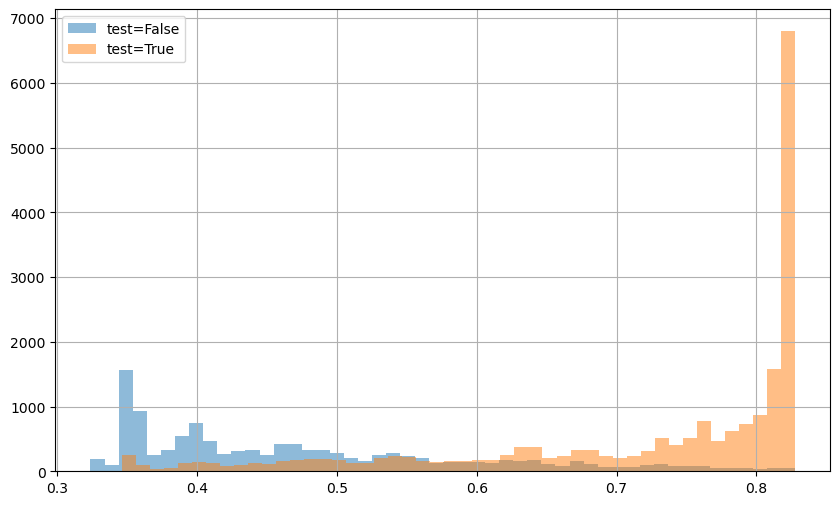

In [65]:
df_ = pd.DataFrame()
df_['pred'] = y_pred
df_['test'] = y_test.to_numpy()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

In [68]:
# Make predictions on the test set
y_pred = regressor_xgb.predict(X_test) > 0.5656565656565657

y_train_estim = regressor_xgb.predict(X_train) > 0.5656565656565657

# Evaluate the model on the train
accuracy_train = accuracy_score(y_train, y_train_estim)
conf_matrix_train = confusion_matrix(y_train, y_train_estim)
classification_rep_train = classification_report(y_train, y_train_estim)

print(f"Accuracy (train): {accuracy_train}")
print(f"Confusion Matrix (train):\n{conf_matrix_train}")
print(f"Classification Report (train):\n{classification_rep_train}")


# Evaluate the model on the test
accuracy_test = accuracy_score(y_test, y_pred)
conf_matrix_test = confusion_matrix(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

print(f"Accuracy (test): {accuracy_test}")
print(f"Confusion Matrix (test):\n{conf_matrix_test}")
print(f"Classification Report (test):\n{classification_rep_test}")

Accuracy (train): 0.8194882011366444
Confusion Matrix (train):
[[37496 10450]
 [12927 68631]]
Classification Report (train):
              precision    recall  f1-score   support

       False       0.74      0.78      0.76     47946
        True       0.87      0.84      0.85     81558

    accuracy                           0.82    129504
   macro avg       0.81      0.81      0.81    129504
weighted avg       0.82      0.82      0.82    129504

Accuracy (test): 0.8204225352112676
Confusion Matrix (test):
[[ 9389  2578]
 [ 3236 17173]]
Classification Report (test):
              precision    recall  f1-score   support

       False       0.74      0.78      0.76     11967
        True       0.87      0.84      0.86     20409

    accuracy                           0.82     32376
   macro avg       0.81      0.81      0.81     32376
weighted avg       0.82      0.82      0.82     32376



/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/anaconda3/envs/env_gust_usa_pricing/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 